<a href="https://colab.research.google.com/github/eugbyte/nlp-experiment/blob/main/Chatbot_babi_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This chatbot is trained using the End-to-End Memory Network

[Summary](https://medium.com/analytics-vidhya/end-to-end-memory-network-highlights-29dba9a6d59b)

[Original Paper](https://arxiv.org/pdf/1503.08895.pdf)

Dataset is from the [Facebook bAbI tasks dataset](www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2.tar.gz)

In [ ]:
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate, LSTM, Embedding
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import tokenize
from copy import deepcopy

nltk.download('wordnet')
nltk.download('punkt')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Data cleaning and encoding

## 1. Load Text

In [ ]:
# from google.colab import files
# files.upload()

In [ ]:
!ls

my_model.h5			     qa1_single-supporting-fact_train.txt
qa1_single-supporting-fact_test.txt  sample_data


In [ ]:
train_data = None
with open('qa1_single-supporting-fact_train.txt', 'r') as f:
  train_data = f.read()

In [ ]:
test_data = None
with open('qa1_single-supporting-fact_test.txt', 'r') as f:
  test_data = f.read()

In [ ]:
type(train_data)
# str

str

In [ ]:
len(train_data)
# 94346

94346

In [ ]:
print(train_data[:100])

# 1 Mary moved to the bathroom.
# 2 John went to the hallway.
# 3 Where is Mary? 	bathroom	1
# 4 Daniel went

1 Mary moved to the bathroom.
2 John went to the hallway.
3 Where is Mary? 	bathroom	1
4 Daniel went


## 2. Text Preprocessing

In [ ]:
def remove_digits(text):
  text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", text)
  return text

In [ ]:
def remove_punc(text):
  text = re.sub(r'[^\w\s]', ' ', text)
  return text

In [ ]:
def lemmat(text):
  wordnet_lemmatizer = WordNetLemmatizer()
  words = tokenize.word_tokenize(text)
  output = [wordnet_lemmatizer.lemmatize(word, 'v') for word in words]  
  return " ".join(output)

In [ ]:
lemmat("ran run running")

'run run run'

In [ ]:
def clean_text(text):
  text = remove_punc(text)
  text = remove_digits(text)
  text = text.strip()
  text = lemmat(text)
  return text

In [ ]:
print(train_data[:100])

1 Mary moved to the bathroom.
2 John went to the hallway.
3 Where is Mary? 	bathroom	1
4 Daniel went


## 3. Generate train test dataset

In [ ]:
def group_s_q_a(X):
  # s = story, q = question, a = answer

  X = train_data.split("\n")
  output = []
  for i in range(len(X)):
    if (i+1) % 3 != 0:
      continue

    q, a, *rest = X[i].split("\t")
    
    q = clean_text(q)

    s = X[i-2] + X[i-1]
    s = clean_text(s)

    s = s.split(" ")
    q = q.split(" ")
    a = a.split(" ")

    output.append( (s, q, a) )

  return output
  

In [ ]:
train_data_list = group_s_q_a(train_data)
test_data_list = group_s_q_a(test_data)

In [ ]:
original_train_data_list = deepcopy(train_data_list)
original_test_data_list = deepcopy(test_data_list)

In [ ]:
# to get the a cumulative representation of the stories

def accum_story(data):

  for i, group in enumerate(data):
    if i == 0:
      continue

    story, qn, ans = group
    prev_story, *rest = data[i-1]

    accum_story = prev_story + story
    data[i] = (accum_story, qn, ans)


In [ ]:
accum_story(train_data_list)
accum_story(test_data_list)

In [ ]:
for i, group in enumerate(original_test_data_list):
  if i > 5:
    break

  story, qn, ans = group
  print(story)

  print(qn)


['Mary', 'move', 'to', 'the', 'bathroom', 'John', 'go', 'to', 'the', 'hallway']
['Where', 'be', 'Mary']
['Daniel', 'go', 'back', 'to', 'the', 'hallway', 'Sandra', 'move', 'to', 'the', 'garden']
['Where', 'be', 'Daniel']
['John', 'move', 'to', 'the', 'office', 'Sandra', 'journey', 'to', 'the', 'bathroom']
['Where', 'be', 'Daniel']
['Mary', 'move', 'to', 'the', 'hallway', 'Daniel', 'travel', 'to', 'the', 'office']
['Where', 'be', 'Daniel']
['John', 'go', 'back', 'to', 'the', 'garden', 'John', 'move', 'to', 'the', 'bedroom']
['Where', 'be', 'Sandra']
['Sandra', 'travel', 'to', 'the', 'office', 'Sandra', 'go', 'to', 'the', 'bathroom']
['Where', 'be', 'Sandra']


## 4. Get unique vocab

In [ ]:
all_data = group_s_q_a(train_data) + group_s_q_a(test_data)
print(all_data)

# [(['Mary', 'moved', 'to', 'the', 'bathroom', 'John', 'went', 'to', 'the', 'hallway'], ['Where', 'is', 'Mary'], ['bathroom'])

[(['Mary', 'move', 'to', 'the', 'bathroom', 'John', 'go', 'to', 'the', 'hallway'], ['Where', 'be', 'Mary'], ['bathroom']), (['Daniel', 'go', 'back', 'to', 'the', 'hallway', 'Sandra', 'move', 'to', 'the', 'garden'], ['Where', 'be', 'Daniel'], ['hallway']), (['John', 'move', 'to', 'the', 'office', 'Sandra', 'journey', 'to', 'the', 'bathroom'], ['Where', 'be', 'Daniel'], ['hallway']), (['Mary', 'move', 'to', 'the', 'hallway', 'Daniel', 'travel', 'to', 'the', 'office'], ['Where', 'be', 'Daniel'], ['office']), (['John', 'go', 'back', 'to', 'the', 'garden', 'John', 'move', 'to', 'the', 'bedroom'], ['Where', 'be', 'Sandra'], ['bathroom']), (['Sandra', 'travel', 'to', 'the', 'office', 'Sandra', 'go', 'to', 'the', 'bathroom'], ['Where', 'be', 'Sandra'], ['bathroom']), (['Mary', 'go', 'to', 'the', 'bedroom', 'Daniel', 'move', 'to', 'the', 'hallway'], ['Where', 'be', 'Sandra'], ['bathroom']), (['John', 'go', 'to', 'the', 'garden', 'John', 'travel', 'to', 'the', 'office'], ['Where', 'be', 'Sandra'

In [ ]:
vocab = set()

for grp in all_data:
  s, q, a = grp
  vocab = vocab.union(set(s))
  vocab = vocab.union(set(a))

In [ ]:
vocab

# {'Daniel',
#  'John',
#  'Mary',
#  'Sandra',
#  'back',
#  'bathroom',
#  'bedroom',
#  'garden',
#  'hallway',
#  'journeyed',
#  'kitchen',
#  'moved',
#  'office',
#  'the',
#  'to',
#  'travelled',
#  'went'}

{'Daniel',
 'John',
 'Mary',
 'Sandra',
 'back',
 'bathroom',
 'bedroom',
 'garden',
 'go',
 'hallway',
 'journey',
 'kitchen',
 'move',
 'office',
 'the',
 'to',
 'travel'}

## 6. Tokenize Text

### 1. Get vectors' max lengths

In [ ]:
# need to add 1 as keras uses 0 for padding
vocab_size = len(vocab) + 1
D = 64

In [ ]:
all_qn_lens = [len(q) for (s, q, a) in all_data]
MAX_QN_LEN = max(all_qn_lens)


In [ ]:
MAX_QN_LEN

3

In [ ]:
# Get the dimension of the longest story
all_story_lens = [len(s) for (s, q, a) in all_data]
MAX_STORY_LEN = max(all_story_lens)

In [ ]:
MAX_STORY_LEN

12

In [ ]:
tokenizer = Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)
tokenizer.word_index

{'back': 9,
 'bathroom': 14,
 'bedroom': 10,
 'daniel': 12,
 'garden': 2,
 'go': 4,
 'hallway': 17,
 'john': 8,
 'journey': 5,
 'kitchen': 13,
 'mary': 16,
 'move': 11,
 'office': 15,
 'sandra': 6,
 'the': 3,
 'to': 1,
 'travel': 7}

In [ ]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=MAX_STORY_LEN, max_question_len=MAX_QN_LEN):
  # Stories
  X = []

  # Questions
  Xq = []

  # Y Correct answer
  Y = []

  for (story, qn, ans) in data:
    # for each story
    x = [word_index[word.lower()] for word in story]
    xq = [word_index[word.lower()] for word in story]

    y = np.zeros(len(word_index) + 1)
    answer = ans[0] # ans is a 1d array. e.g. ["garden"]
    y[word_index[answer]] = 1 

    X.append(x)
    Xq.append(xq)
    Y.append(y)

  return (pad_sequences(X, maxlen=MAX_STORY_LEN), pad_sequences(Xq, maxlen=MAX_QN_LEN), np.array(Y))

In [ ]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data_list)
inputs_test, queries_test, answers_test = vectorize_stories(test_data_list)

In [ ]:
inputs_train

array([[ 0,  0, 16, ...,  1,  3, 17],
       [17, 12,  4, ...,  1,  3,  2],
       [ 3,  2,  8, ...,  1,  3, 14],
       ...,
       [17, 16,  5, ...,  1,  3, 10],
       [ 3, 10, 12, ...,  1,  3, 13],
       [ 3, 13,  6, ...,  1,  3,  2]], dtype=int32)

In [ ]:
answers_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [ ]:
print(inputs_train.shape, queries_train.shape, answers_train.shape)
# (1000, 12) (1000, 3) (1000, 18)

(1000, 12) (1000, 3) (1000, 18)


# Build the RNN model

## Theory

Recall that:
1.   The story vector is multiplied against its embedding matrix (M)
2.   The question vector is multiplied against its embedding matrix (Q)
3.   The product (after softmax) represents the most probable sentence. The product matrix will of dimension max_story_len x max_qn_ln
4.   To get a **continous representation**:  
     a.    We start again by encoding the sentences of the story as vectors (C). C is of dimension max_story_len x max_qn_ln  
     a.    Since C's dimension is compatible with the product matrix, the product matrix is *added* to C. 
     b.    Afterwards, the result is *concatenated* with the embedded question matrix. The axis concatenated is the embedding dimension. This way, the features learn are accumulated 
5.   This final embedded matrix is then fed to the LSTM layer.
5.   For the next recursion, the steps repeat iself based on the continued representation

## Build the attention layer

#### 2 input layers



In [ ]:
# This model will have 2 input layers, being the story input and the question input
story_sequence = Input((MAX_STORY_LEN, ))
q_input = Input((MAX_QN_LEN, ))

print(story_sequence.shape)
# (None, 12)
print(q_input.shape)
# (None, 3)

(None, 12)
(None, 3)


#### Embedded matrix M

In [ ]:
m = Embedding(input_dim=vocab_size, output_dim=D)(story_sequence)
m = Dropout(0.3)(m)

print(m.shape)
# (None, 12, 64)

(None, 12, 64)


#### Embedded matrix C

In [ ]:
c = Embedding(input_dim=vocab_size, output_dim=MAX_QN_LEN)(story_sequence)
c = Dropout(0.3)(c)

print(c.shape)
# (None, 12, 3)

(None, 12, 3)


#### Embedded matrix Q

In [ ]:
# Embedded matrix q

q = Embedding(input_dim=vocab_size, output_dim=D, input_length=MAX_QN_LEN)(q_input)
q = Dropout(0.3)(q)

print(q.shape)
# (None, 3, 64)

(None, 3, 64)


#### Continuous representation

In [ ]:
# Take the inner product between query and each story vector (m), followed by softmax operation, to find the best match
x = dot([m, q], axes=(2, 2))
x = Activation('softmax')(x)
print(x.shape)
# (None, 12, 3)

(None, 12, 3)


In [ ]:
# Add product matrix with C embedded story matrix
x = add([x, c])
print(x.shape)
# (None, 12, 3)

(None, 12, 3)


In [ ]:
# Permutation pattern does not include the samples dimension. Indexing starts at 1. 
# For instance, (2, 1) permutes the first and second dimensions of the input.
# Right now, the continued_match dimension is (samples, story_maxlen, query_maxlen)
# Need to change to (samples, query_maxlen, story_maxlen), since you are going to concactenate with the question_encoded later

x = Permute((2, 1))(x)
print(x.shape)
# (None, 3, 12)

(None, 3, 12)


In [ ]:
# "concactenate" means append to specified axis (defaults to largest axis), as distinct from "add", which does mathematical addition between matrices
# "concactenate" results in a change in the dimension, "add" does not

x = concatenate([x, q])
print(x.shape)
# (None, 3, 76)

(None, 3, 76)


## 3. Build the LSTM layer

In [ ]:
x = LSTM(32)(x)
print(x.shape)

x = Dropout(0.3)(x)
x = Dense(vocab_size, activation="softmax")(x)

print(x.shape)
# (None, 18)

(None, 32)
(None, 18)


In [ ]:
model = Model([story_sequence, q_input], x)

## 4. Compile the model

In [ ]:
model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 3)]          0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 12, 64)       1152        input_7[0][0]                    
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 3, 64)        1152        input_8[0][0]                    
____________________________________________________________________________________________

## 5. Train the model

In [ ]:
r = model.fit([inputs_train, queries_train], answers_train, batch_size=32, epochs=600, validation_data=([inputs_test, queries_test], answers_train) )

Epoch 1/600
32/32 [==============================] - 2s 21ms/step - loss: 2.7077 - accuracy: 0.1188 - val_loss: 2.1415 - val_accuracy: 0.1730
Epoch 2/600
32/32 [==============================] - 0s 9ms/step - loss: 2.0567 - accuracy: 0.1926 - val_loss: 1.8240 - val_accuracy: 0.4890
Epoch 3/600
32/32 [==============================] - 0s 9ms/step - loss: 1.8903 - accuracy: 0.2240 - val_loss: 1.7289 - val_accuracy: 0.4280
Epoch 4/600
32/32 [==============================] - 0s 9ms/step - loss: 1.7696 - accuracy: 0.2875 - val_loss: 1.6467 - val_accuracy: 0.5650
Epoch 5/600
32/32 [==============================] - 0s 9ms/step - loss: 1.7045 - accuracy: 0.3526 - val_loss: 1.5679 - val_accuracy: 0.5650
Epoch 6/600
32/32 [==============================] - 0s 9ms/step - loss: 1.5992 - accuracy: 0.4364 - val_loss: 1.4997 - val_accuracy: 0.5650
Epoch 7/600
32/32 [==============================] - 0s 9ms/step - loss: 1.5493 - accuracy: 0.5026 - val_loss: 1.4529 - val_accuracy: 0.5650
Epoch 8/600


## 6. Evaluate the model

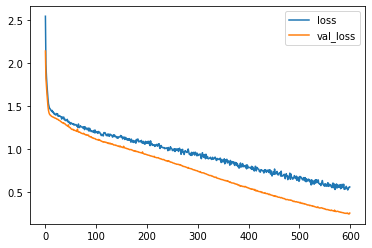

In [ ]:
# Plot accuracy per iteration

plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()


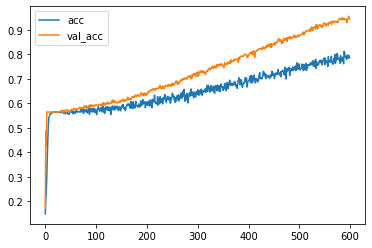

In [ ]:
# Plot accuracy per iteration

plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()


In [ ]:
score, accuracy = model.evaluate([inputs_test, queries_test], answers_train, batch_size=32)
print(score, accuracy)
# 0.8433627486228943 0.6840000152587891

32/32 [==============================] - 0s 3ms/step - loss: 0.2598 - accuracy: 0.9450
0.2597712576389313 0.9449999928474426


## 7. Save the model

In [ ]:
model.save("my_model.h5")
!ls

my_model.h5			     qa1_single-supporting-fact_train.txt
qa1_single-supporting-fact_test.txt  sample_data


In [ ]:
# files.download("babi.h5")

## 8. Make predictions

In [ ]:
ans_dict = {}
for word, index in tokenizer.word_index.items():
  ans_dict[index] = word

In [ ]:
ans_dict

{1: 'to',
 2: 'garden',
 3: 'the',
 4: 'go',
 5: 'journey',
 6: 'sandra',
 7: 'travel',
 8: 'john',
 9: 'back',
 10: 'bedroom',
 11: 'move',
 12: 'daniel',
 13: 'kitchen',
 14: 'bathroom',
 15: 'office',
 16: 'mary',
 17: 'hallway'}

In [ ]:
def predict_ans(inputs_test: np.ndarray, queries_test: np.ndarray, row_index=0):
  y_preds = model.predict([inputs_test, queries_test] )
  y_pred = y_preds[row_index]
  max_index = np.argmax(y_pred)

  print(original_test_data_list[row_index])
  print("answer", ans_dict[max_index])

  return ans_dict[max_index]

In [ ]:
for i in range(10):
  predict_ans(inputs_test, queries_test, row_index=i)
  print()

(['Mary', 'move', 'to', 'the', 'bathroom', 'John', 'go', 'to', 'the', 'hallway'], ['Where', 'be', 'Mary'], ['bathroom'])
answer bathroom

(['Daniel', 'go', 'back', 'to', 'the', 'hallway', 'Sandra', 'move', 'to', 'the', 'garden'], ['Where', 'be', 'Daniel'], ['hallway'])
answer hallway

(['John', 'move', 'to', 'the', 'office', 'Sandra', 'journey', 'to', 'the', 'bathroom'], ['Where', 'be', 'Daniel'], ['hallway'])
answer hallway

(['Mary', 'move', 'to', 'the', 'hallway', 'Daniel', 'travel', 'to', 'the', 'office'], ['Where', 'be', 'Daniel'], ['office'])
answer office

(['John', 'go', 'back', 'to', 'the', 'garden', 'John', 'move', 'to', 'the', 'bedroom'], ['Where', 'be', 'Sandra'], ['bathroom'])
answer bathroom

(['Sandra', 'travel', 'to', 'the', 'office', 'Sandra', 'go', 'to', 'the', 'bathroom'], ['Where', 'be', 'Sandra'], ['bathroom'])
answer bathroom

(['Mary', 'go', 'to', 'the', 'bedroom', 'Daniel', 'move', 'to', 'the', 'hallway'], ['Where', 'be', 'Sandra'], ['bathroom'])
answer bathroom